In [1]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader
from deeppavlov.models.preprocessors.capitalization import CapitalizationPreprocessor
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2018-08-01 23:38:46.406 DEBU

In [67]:
#Supress default INFO logging
# not working :(
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Read data

In [68]:
reader = OntonotesReader()
dataset = reader.read(data_path='data/')
print(dataset.keys())
print('Num of train sentences: {}'.format(len(dataset['train'])))
print('Num of test sentences: {}'.format(len(dataset['test'])))

dict_keys(['train', 'valid', 'test'])
Num of train sentences: 75187
Num of test sentences: 9479


#### Select few examples randomly

In [69]:
def split_examples(examples: list):
    tokens = []
    tags = []
    for ex in examples:
        tokens.append(ex[0])
        tags.append(ex[1])
    return tokens, tags

In [70]:
n_examples = 10
# np.random.seed(12)
# indices = np.random.choice(len(dataset['train']), size=n_examples)
indices = (3,4)
# indices = (10,20,30,40,50,61,72,83,94,105)
examples = [dataset['train'][i] for i in indices]
print(examples)
tokens,tags = split_examples(examples)
print(tokens)
print(tags)

[(['Standing', 'tall', 'on', 'Taihang', 'Mountain', 'is', 'the', 'Monument', 'to', 'the', 'Hundred', 'Regiments', 'Offensive', '.'], ['O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'O']), (['It', 'is', 'composed', 'of', 'a', 'primary', 'stele', ',', 'secondary', 'steles', ',', 'a', 'huge', 'round', 'sculpture', 'and', 'beacon', 'tower', ',', 'and', 'the', 'Great', 'Wall', ',', 'among', 'other', 'things', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'O', 'O', 'O', 'O', 'O'])]
[['Standing', 'tall', 'on', 'Taihang', 'Mountain', 'is', 'the', 'Monument', 'to', 'the', 'Hundred', 'Regiments', 'Offensive', '.'], ['It', 'is', 'composed', 'of', 'a', 'primary', 'stele', ',', 'secondary', 'steles', ',', 'a', 'huge', 'round', 'sculpture', 'and', 'beacon', 'tower', ',', 'and', 'th

### Convert tags to binary

In [66]:
def tags2binary(tags):
    tags = copy.deepcopy(tags)
    for seq in tags:
        for i in range(len(seq)):
            if seq[i] != 'O':
                seq[i] = 'T'
    return tags

tags = tags2binary(tags)
print(tags)      

[['O', 'O', 'O', 'T', 'T', 'O', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'T', 'T', 'O', 'O', 'O', 'O', 'O']]


### Elmo embedder

In [6]:
class ElmoEmbedder():
    def __init__(self):
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        self.sess = sess

    def get_tokens_embeddings(self, tokens_input: list, tokens_length:list=None):
        if not tokens_length:
            if isinstance(tokens_input[0], list):
                tokens_length = [len(seq) for seq in tokens_input]
            else:
                tokens_length = len(tokens_input)
        # print('tokens_length = {}'.format(tokens_length))
        embeddings = self.elmo(
                        inputs={
                            "tokens": tokens_input,
                            "sequence_len": tokens_length
                        },
                        signature="tokens",
                        as_dict=True)["elmo"]
        embeddings = self.sess.run([embeddings])
        return embeddings[0]

### Add padding to tokens

In [7]:
def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        tokens_length = []
        for seq in tokens:
            tokens_length.append(len(seq))
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens, tokens_length
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')

### Transform tokens to lower case

In [8]:
def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    print(tokens_lower)
    return tokens_lower

### Test embedders

In [11]:
# elmo = ElmoEmbedder()
# tokens_input, tokens_length = add_padding(tokens)
# embeddings = elmo.get_tokens_embeddings(tokens_input, tokens_length)
# print('Embeddings: {}'.format(embeddings))
# print('Embeddings shape: {}'.format(embeddings.shape))
# del embeddings

In [12]:
# glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
# embed = glove(tokens)
# print(len(embed[0]))
# print(len(embed[1]))

In [13]:
# cap_prep = CapitalizationPreprocessor(pad_zeros=False)
# cap_prep(tokens)

### Main embedder class. Concatenates different embeddings

In [14]:
def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

In [30]:
class CompositeEmbedder():
    def __init__(self, use_elmo=True, elmo_scale=1., use_cap_feat=False, use_glove=False):
        self.use_elmo = use_elmo
        self.elmo_scale = elmo_scale
        self.use_cap_feat = use_cap_feat
        self.use_glove = use_glove
        if self.use_elmo:
            self.elmo = ElmoEmbedder()
        if self.use_cap_feat:
            self.cap_prep = CapitalizationPreprocessor()
        if self.use_glove:
            self.glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
        
    def embed(self, tokens: list):
        if isinstance(tokens[0], str):
            tokens = [tokens]
        # Get ELMo embeddings
        if self.use_elmo:
            tokens_input, tokens_length = add_padding(tokens)
            print(tokens_length)
            embeddings = self.elmo.get_tokens_embeddings(tokens_input, tokens_length)
            embeddings *= self.elmo_scale
            embed_size = embeddings.shape[-1]
            print(embeddings.shape)
            print(embed_size)

        # Use capitalization features
        if self.use_cap_feat:
            print('Use capitalization features')
            cap_features = self.cap_prep(tokens)
    #         print(cap_features)
            print(cap_features.shape)
            embeddings = np.concatenate((embeddings, cap_features), axis=2)
            embed_size = embeddings.shape[-1]
            print(embeddings.shape)

        # Use GloVe embeddings
        if self.use_glove:
            print('Use GloVe')
            
            glove_embed = self.glove(to_lower_case(tokens))
            glove_embed = np.array(glove_embed)
            if not self.use_elmo:
                embeddings = glove_embed
            else: 
                embeddings = np.concatenate((embeddings, glove_embed), axis=2)
            embed_size = embeddings.shape[-1]
            print(embeddings.shape)
        
        return embeddings

#### Calculate tokens similarities to the tag prototype in the space of ELMo embeddings 

In [31]:
def calc_sim(token_vec, ne_prototype)->dict:
    sim = {}
    sim['euc_dist'] = np.linalg.norm(token_vec - ne_prototype)
    sim['dot_prod'] = np.dot(token_vec, ne_prototype)
    sim['cosine'] = np.dot(token_vec, ne_prototype)/(np.linalg.norm(token_vec)*np.linalg.norm(ne_prototype))
    return sim

In [32]:
def calc_sim_batch(tokens: list, embeddings: np.ndarray, ne_prototype: np.ndarray)->list:
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_list[i].append(calc_sim(token_vec, ne_prototype))
    return sim_list

In [33]:
def estimate_sim_to_ne_prototype(tokens: list, tags: list, embedder: CompositeEmbedder):
    # Calculate embeddings
    embeddings = embedder.embed(tokens)
    
    # Calculate average vector for ne-tags
    embed_size = embeddings.shape[-1]
    ne_prototype = np.zeros((embed_size,))
    tokens_length = get_tokens_len(tokens)
    n_ne_tags = 0
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            if tags[i][j] == 'T':
                ne_prototype += embeddings[i,j,:].reshape((embed_size,))
                n_ne_tags += 1
    ne_prototype /= n_ne_tags
    print('ne mean vector: {}'.format(ne_prototype))
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)
            
    return sim_list, embeddings, tokens_length, ne_prototype

In [34]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, use_cap_feat=True, use_glove=True)

INFO:tensorflow:Initialize variable module_2/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


2018-08-01 23:47:48.994 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module_2/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


2018-08-01 23:47:49.1 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


2018-08-01 23:47:49.7 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


2018-08-01 23:47:49.14 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


2018-08-01 23:47:49.20 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


2018-08-01 23:47:49.29 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


2018-08-01 23:47:49.36 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


2018-08-01 23:47:49.42 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module_2/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


2018-08-01 23:47:49.49 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


2018-08-01 23:47:49.56 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


2018-08-01 23:47:49.62 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


2018-08-01 23:47:49.68 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


2018-08-01 23:47:49.76 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


2018-08-01 23:47:49.81 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


2018-08-01 23:47:49.87 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module_2/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


2018-08-01 23:47:49.93 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


2018-08-01 23:47:49.99 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


2018-08-01 23:47:49.107 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


2018-08-01 23:47:49.114 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


2018-08-01 23:47:49.122 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


2018-08-01 23:47:49.132 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


2018-08-01 23:47:49.140 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


2018-08-01 23:47:49.149 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module_2/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


2018-08-01 23:47:49.156 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module_2/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


2018-08-01 23:47:49.163 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module_2/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


2018-08-01 23:47:49.169 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-01 23:47:49.177 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-01 23:47:49.183 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-01 23:47:49.189 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-01 23:47:49.195 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-01 23:47:49.202 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-01 23:47:49.209 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-01 23:47:49.215 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-01 23:47:49.221 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-01 23:47:49.227 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-01 23:47:49.234 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-01 23:47:49.241 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-01 23:47:49.248 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_2/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


2018-08-01 23:47:49.253 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_2/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


In [35]:
sims_ne, embeddings, tokens_length, ne_prototype = estimate_sim_to_ne_prototype(tokens, tags, embedder)
print('Distances of token vectors to ne prototype: {}'.format(sims_ne))

[14, 28]
(2, 28, 1024)
1024
Use capitalization features
(2, 28, 4)
(2, 28, 1028)
Use GloVe
[['standing', 'tall', 'on', 'taihang', 'mountain', 'is', 'the', 'monument', 'to', 'the', 'hundred', 'regiments', 'offensive', '.'], ['it', 'is', 'composed', 'of', 'a', 'primary', 'stele', ',', 'secondary', 'steles', ',', 'a', 'huge', 'round', 'sculpture', 'and', 'beacon', 'tower', ',', 'and', 'the', 'great', 'wall', ',', 'among', 'other', 'things', '.']]
(2, 28, 1128)
ne mean vector: [-0.13697986 -0.02443596 -0.183432   ... -0.20988     0.43461599
  0.22691433]
Distances of token vectors to ne prototype: [[{'euc_dist': 17.853013562487345, 'dot_prod': 62.95430820293746, 'cosine': 0.3279110174907391}, {'euc_dist': 17.583414672166892, 'dot_prod': 51.47898400401348, 'cosine': 0.2822041801877988}, {'euc_dist': 14.293457865681205, 'dot_prod': 52.251479808178125, 'cosine': 0.35318168636958763}, {'euc_dist': 16.89811740422804, 'dot_prod': 108.10636830273414, 'cosine': 0.5204032540764532}, {'euc_dist': 15

#### Flatten arrays

In [36]:
def flatten(emdebbings, tokens_length, tags, sim_list):
    emdebbings_flat = []
    tags_flat = []
    sims_flat = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            emdebbings_flat.append(embeddings[i,j,:])
            tags_flat.append(1 if tags[i][j] == 'T' else 0)
            for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                sims_flat[sim_type].append(sim_list[i][j][sim_type])
    emdebbings_flat = np.array(emdebbings_flat)
    tags_flat = np.array(tags_flat)
    for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
        sims_flat[sim_type] = np.array(sims_flat[sim_type])
    return emdebbings_flat, tags_flat, sims_flat

In [37]:
emdebbings_flat, tags_flat, sims_flat = flatten(embeddings, tokens_length, tags, sims_ne)
print(emdebbings_flat.shape)
print(tags_flat.shape)
print(sims_flat.keys())
print(sims_flat['cosine'].shape)

(42, 1128)
(42,)
dict_keys(['euc_dist', 'dot_prod', 'cosine'])
(42,)


In [38]:
print('{:<8s}\t{:<8s}\t{:<8s}\t{:<8s}\t{:<8s}'.format('TOKEN', 'EUC_DIST', 'DOT_PROD', 'COSINE_SIM', 'TAG'))
for i in range(len(tokens)):
    for j in range(len(tokens[i])):
        print('{:<8s}\t{:<8.3f}\t{:<8.3f}\t{:<8.3f}\t{:<8s}'.format(tokens[i][j], sims_ne[i][j]['euc_dist'], sims_ne[i][j]['dot_prod'], sims_ne[i][j]['cosine'], tags[i][j]))

TOKEN   	EUC_DIST	DOT_PROD	COSINE_SIM	TAG     
Standing	17.853  	62.954  	0.328   	O       
tall    	17.583  	51.479  	0.282   	O       
on      	14.293  	52.251  	0.353   	O       
Taihang 	16.898  	108.106 	0.520   	T       
Mountain	15.312  	116.978 	0.589   	T       
is      	12.817  	62.219  	0.444   	O       
the     	10.748  	95.789  	0.650   	T       
Monument	13.760  	132.675 	0.681   	T       
to      	12.884  	89.526  	0.556   	T       
the     	10.874  	106.193 	0.681   	T       
Hundred 	17.080  	140.051 	0.621   	T       
Regiments	15.486  	110.751 	0.563   	T       
Offensive	15.851  	104.229 	0.531   	T       
.       	15.222  	39.290  	0.265   	O       
It      	15.224  	55.217  	0.345   	O       
is      	14.666  	36.641  	0.261   	O       
composed	16.869  	36.580  	0.221   	O       
of      	15.354  	35.502  	0.241   	O       
a       	14.370  	45.753  	0.318   	O       
primary 	16.157  	44.453  	0.273   	O       
stele   	15.491  	44.389  	0.286   	O       
,     

### Calculate some metrics

In [39]:
ne_cosine_sim_min = np.min(sims_flat['cosine'][tags_flat == 1])
ne_cosine_sim_max = np.max(sims_flat['cosine'][tags_flat == 1])
words_cosine_sim_min = np.min(sims_flat['cosine'][tags_flat == 0])
words_cosine_sim_max = np.max(sims_flat['cosine'][tags_flat == 0])
print('Cosine similarity:')
print('NE\tmin={:.3f}\tmax={:.3f}'.format(ne_cosine_sim_min, ne_cosine_sim_max))
print('words\tmin={:.3f}\tmax={:.3f}'.format(words_cosine_sim_min, words_cosine_sim_max))

Cosine similarity:
NE	min=0.520	max=0.681
words	min=0.221	max=0.444


### Embeddings visualisation

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
emdebbings_flat_red = PCA(n_components=50).fit_transform(emdebbings_flat)
print(emdebbings_flat_red.shape)
tsne = TSNE(n_components=2, method='exact', init='pca')
embeddings_2d = tsne.fit_transform(emdebbings_flat)
# ne_prototype_2d = tsne.fit_transform(ne_prototype)

(42, 42)


(42, 2)


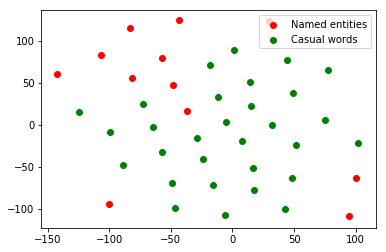

In [42]:
print(embeddings_2d.shape)
plt.scatter(embeddings_2d[tags_flat == 1, 0],embeddings_2d[tags_flat == 1, 1], c='r', label='Named entities')
plt.scatter(embeddings_2d[tags_flat == 0, 0],embeddings_2d[tags_flat == 0, 1], c='g', label='Casual words')
# plt.scatter(ne_prototype_2d[0], ne_prototype_2d[1], c='g', marker='+', label='NE prototype')
plt.legend()

### Test model

In [71]:
test_sentences = dataset['test'][3:8]
print(test_sentences)
tokens_test, tags_test = split_examples(test_sentences)
print(tokens_test)
print(tags_test)

[(['Dear', 'viewers', ',', 'the', 'China', 'News', 'program', 'will', 'end', 'here', '.'], ['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O']), (['This', 'is', 'Xu', 'Li', '.'], ['O', 'O', 'B-PERSON', 'I-PERSON', 'O']), (['Thank', 'you', 'everyone', 'for', 'watching', '.'], ['O', 'O', 'O', 'O', 'O', 'O']), (['Coming', 'up', 'is', 'the', 'Focus', 'Today', 'program', 'hosted', 'by', 'Wang', 'Shilin', '.'], ['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O']), (['Good-bye', ',', 'dear', 'viewers', '.'], ['O', 'O', 'O', 'O', 'O'])]
[['Dear', 'viewers', ',', 'the', 'China', 'News', 'program', 'will', 'end', 'here', '.'], ['This', 'is', 'Xu', 'Li', '.'], ['Thank', 'you', 'everyone', 'for', 'watching', '.'], ['Coming', 'up', 'is', 'the', 'Focus', 'Today', 'program', 'hosted', 'by', 'Wang', 'Shilin', '.'], ['Good-bye', ',', 'dear', 'viewers', '.']]
[['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'B-PERSON', 'I-PERSON', 'O

In [72]:
def infer_tags(tokens: len, ne_prototype: np.ndarray, embedder: CompositeEmbedder):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    print(tokens_length)
    
    # Calculate embeddings
    embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)
    
    threshold = 0.5
    tags = [['T' if sim_list[i][j]['cosine'] > threshold else 'O' for j in range(tokens_length[i])] for i in range(len(tokens_length))]
    print(tags)
    print(len(tags))
    return tags, sim_list

In [73]:
tags_test_pred, sim_list = infer_tags(tokens_test, ne_prototype, embedder)
print(sim_list)

[11, 5, 6, 12, 5]
[11, 5, 6, 12, 5]
(5, 12, 1024)
1024
Use capitalization features
(5, 12, 4)
(5, 12, 1028)
Use GloVe
[['dear', 'viewers', ',', 'the', 'china', 'news', 'program', 'will', 'end', 'here', '.'], ['this', 'is', 'xu', 'li', '.'], ['thank', 'you', 'everyone', 'for', 'watching', '.'], ['coming', 'up', 'is', 'the', 'focus', 'today', 'program', 'hosted', 'by', 'wang', 'shilin', '.'], ['good-bye', ',', 'dear', 'viewers', '.']]
(5, 12, 1128)
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O']]
5
[[{'euc_dist': 19.81533195169285, 'dot_prod': 43.99112333294333, 'cosine': 0.21772083474121598}, {'euc_dist': 18.824018580150977, 'dot_prod': 28.241798357007095, 'cosine': 0.15515582799497402}, {'euc_dist': 14.617330913171882, 'dot_prod': 32.22320573361427, 'cosine': 0.23687855255588186}, {'euc_dist': 13.624608680618486, 'dot_prod': 51.467